<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/Primer_analisis_de_los_datos_CTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Se han cargado todos los datos en una carpeta de Drive para luego poder acceder a ellos a traves de un Colab Notebook. 

El primer paso va a ser cargar los datos en arrays de numpy o dataframes de panda.

En el caso de los gamma tenemos un problema porque hay demasiados datos, lo tendremos que hacer por lotes.



### La estructura del análisis será la siguiente:
  1. Análisis estádistico de cada muestra de valores. Para cada conjunto de datos (helio, hierro, electrones...) haremos un análisis estadístico de las zonas de mayor incidencia, máximos valores de intensidad y algunos datos más.
  2. Después de este análisis procederemos con la clasificación por medio de CNN's. Primero entre gamma vs. cada una de las otras. Y luego una clasificación multiclase.

      - Para la arquitectura de nuestra CNN clasificadora, se va a recurrir a la propuesta por Rodrigo en su TFG. Más adelante se probarán otras arquitecturas y se investigará el método de transfer learning así como el de Data Augmentation aplicado a nuestro problema. 



In [ ]:
#cargamos librerias 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import pandas as pd
import glob 
import re
import shutil
import zipfile as zip
import gzip
import sys

In [ ]:
a=np.array([1,2,3,4])

In [ ]:
b=a[:2].copy()

In [ ]:
b[1]=0

In [ ]:
b

array([1, 0])

In [ ]:
for i in ["gamma_total","electron","helium", "proton","iron","silicon","nitrogen"]:
  aux="\includegraphics[width=17 cm]{"+str(i)+".png} \n"
  print(aux)

\includegraphics[width=17 cm]{gamma_total.png} 

\includegraphics[width=17 cm]{electron.png} 

\includegraphics[width=17 cm]{helium.png} 

\includegraphics[width=17 cm]{proton.png} 

\includegraphics[width=17 cm]{iron.png} 

\includegraphics[width=17 cm]{silicon.png} 

\includegraphics[width=17 cm]{nitrogen.png} 



### **Esta parte es la de procesado de los datos para obtener los archivos .npy con lo necesario.**

In [ ]:
#para el [electron,helium, proton,iron,silicon,nitrogen] podemos hacer lo mismo pues tienen el mismo formato
elements=["gamma","electron","helium", "proton","iron","silicon","nitrogen"]
#y para los gamma tenemos que buscar la forma de lidiar con tantos datos despues de edscomprimierlos, para 
#descomprimierlos es igual que con los otros

#### Extracciónd datos helio, proton, etc...

In [ ]:
#lo primero que vamos a hacer es descomprimir los gunzip que tenemos
elements=["gamma","electron","helium", "proton","iron","silicon","nitrogen"]

ground_dir="/content/drive/MyDrive/TFG arturo"
os.chdir(ground_dir)
for i in elements:
  print(i)
  element_dir=os.path.join(ground_dir,i)
  os.chdir(element_dir)
  files_names=glob.glob("*.dt.gz")
  print(files_names)
  new_files_names=[h.replace(".dt.gz",".dt") for h in files_names]
  for j in range(len(files_names)):
    with gzip.open(os.path.join(element_dir,files_names[j]),"rb") as f:
      fp=open(new_files_names[j],"wb")
      aux=f.read()
      fp.write(aux)
      fp.close()

electron
['electron_tel_1_run_06.dt.gz', 'electron_tel_1_run_19.dt.gz', 'electron_tel_1_run_20.dt.gz', 'electron_tel_1_run_22.dt.gz', 'electron_tel_1_run_39.dt.gz', 'electron_tel_1_run_04.dt.gz', 'electron_tel_1_run_02.dt.gz', 'electron_tel_1_run_24.dt.gz', 'electron_tel_1_run_26.dt.gz', 'electron_tel_1_run_31.dt.gz', 'electron_tel_1_run_33.dt.gz', 'electron_tel_1_run_37.dt.gz', 'electron_tel_1_run_16.dt.gz', 'electron_tel_1_run_08.dt.gz', 'electron_tel_1_run_17.dt.gz', 'electron_tel_1_run_11.dt.gz', 'electron_tel_1_run_28.dt.gz', 'electron_tel_1_run_15.dt.gz', 'electron_tel_1_run_35.dt.gz', 'electron_tel_1_run_13.dt.gz', 'electron_tel_1_run_30.dt.gz', 'electron_tel_1_run_34.dt.gz', 'electron_tel_1_run_14.dt.gz', 'electron_tel_1_run_09.dt.gz', 'electron_tel_1_run_29.dt.gz', 'electron_tel_1_run_12.dt.gz', 'electron_tel_1_run_10.dt.gz', 'electron_tel_1_run_32.dt.gz', 'electron_tel_1_run_36.dt.gz', 'electron_tel_1_run_05.dt.gz', 'electron_tel_1_run_01.dt.gz', 'electron_tel_1_run_23.dt.gz'

In [ ]:
#una vez podamos acceder a los archivos .dt lo que hacemos es cargarlos en un dataframe
#tenemos que retirar las columnas que no nos interesan y tambien, ordenarlos segun el evento que sea (dentro de cada RUN)
#vamosa crear archivos npy para todos menos para gamma
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
ground_dir="/content/drive/MyDrive/TFG arturo"

elements_dt=["helium", "proton","iron","silicon","nitrogen"]
#elements_dt=["electron"]

for i in range(len(elements_dt)):
  name_npy=os.path.join(npy_dir,elements_dt[i]+".npy")
  element_dir=os.path.join(ground_dir,elements_dt[i])
  os.chdir(element_dir)
  files_names=glob.glob("*.dt")
  #creamos una lista con un dataframe por cada archivo
  dt_list=[]
  for j in range(len(files_names)):
    aux_df=pd.read_csv(os.path.join(element_dir,files_names[j]),sep='  ',names=["1","2","3","4","5","6"],engine="python")
    #ahora la procesamos y la guardamos en un npy
    value_auf=aux_df[['1','3','4','5']].copy()
    #tenemos que agupar los valores y normalizarlos 
    value_auf.loc[value_auf["5"]<0]=0
    max_aux=np.amax(value_auf["5"])
    value_auf["5"]=value_auf["5"]/max_aux
    x_minimo=min(value_auf['3'])
    y_minimo=min(value_auf['4'])
    value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/333))
    value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/192))
    event_aux=value_auf["1"].unique()
    for k in event_aux:
      #cada evento tiene que ponerse en una imagen con sus valores
      array_aux=value_auf.loc[value_auf["1"]==k][["3","4","5"]]
      #lo que vamos a hacer es qponer los valores en una matriz creada de antemano y guardar esa matrix
      matrix_aux=np.zeros((60-5,131-38))
      matrix_aux[array_aux["3"].to_numpy()-5,array_aux["4"].to_numpy()-39]=array_aux["5"].to_numpy()
      dt_list.append(matrix_aux)
  np.save(name_npy,np.array(dt_list))
  #ya tenemos el datafram con las cosas, ahora la procesamos y la guardamos en un npy


In [ ]:
a,b=[1,2], [4,5]

[1, 2]

In [ ]:
proton=np.load("/content/drive/MyDrive/TFG arturo/npy archivos/proton.npy")

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,17):
  plt.subplot(4,4,i)
  plt.imshow(proton[i])
  

In [ ]:
#forma de conocer el tamaño de un array cargado por medio de npy file
print(proton.nbytes/1e9)
import sys
print(sys.getsizeof(proton)/1e9)
print(os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/proton.npy").st_size/1e9)

In [ ]:
#nos queda lidiar con los datos de gamma
#tenemos que buscar una forma de que no guardemos archivos npy de mas de un giga (por poner un limite)
from tqdm.notebook import tqdm

limit_size=3.5e8 #bytes 
ground_dir="/content/drive/MyDrive/TFG arturo"

npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
lista_elements=["electron","gamma","helium", "proton","iron","silicon","nitrogen"]

#elements_dt=["electron"]


for elements_dt in lista_elements:
  contador_nombre=0
  element_dir=os.path.join(ground_dir,elements_dt)
  os.chdir(element_dir)
  files_names=glob.glob("*.dt")
  #creamos una lista con un dataframe por cada archivo
  dt_list=[]  
  for j in range(len(files_names)):
    print(j,end="\n")
    aux_df=pd.read_csv(os.path.join(element_dir,files_names[j]),sep='  ',names=["1","2","3","4","5","6"],engine="python")
    #ahora la procesamos y la guardamos en un npy
    value_auf=aux_df[['1','3','4','5']].copy()
    #tenemos que agupar los valores y normalizarlos 
    value_auf.loc[value_auf["5"]<0]=0
    max_aux=np.amax(value_auf["5"])
    value_auf["5"]=value_auf["5"]/max_aux
    x_minimo=min(value_auf['3'])
    y_minimo=min(value_auf['4'])
    value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/333))
    value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/192))
    event_aux=value_auf["1"].unique()
    for k in tqdm(range(np.shape(event_aux)[0])):
      #cada evento tiene que ponerse en una imagen con sus valores
      array_aux=value_auf.loc[value_auf["1"]==event_aux[k]][["3","4","5"]]
      #lo que vamos a hacer es qponer los valores en una matriz creada de antemano y guardar esa matrix
      #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
      matrix_aux=np.zeros((60-5,131-38))
      matrix_aux[array_aux["3"].to_numpy()-5,array_aux["4"].to_numpy()-39]=array_aux["5"].to_numpy()
      dt_list.append(matrix_aux)
      if (np.array(dt_list).nbytes>limit_size):
        name_npy=os.path.join(npy_dir,elements_dt+"_"+str(contador_nombre)+".npy")
        np.save(name_npy,np.array(dt_list))
        del dt_list
        dt_list=[]
        contador_nombre+=1
  name_npy=os.path.join(npy_dir,elements_dt+"_"+str(contador_nombre)+".npy")
  np.save(name_npy,np.array(dt_list))
  #ya tenemos el datafram con las cosas, ahora la procesamos y la guardamos en un npy


0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



0



1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29


Buffered data was truncated after reaching the output size limit.

In [ ]:
os.chdir(npy_dir)
gamma_list=glob.glob("*[0-9].npy")
total=0
for i in gamma_list:
  total+= os.stat(os.path.join("/content/drive/MyDrive/TFG arturo/npy archivos",i)).st_size

print(total)
print( os.stat(os.path.join("/content/drive/MyDrive/TFG arturo/npy archivos","gamma_deltiron.npy")).st_size)

3273192208
3273190928


In [ ]:
#esto es para cada run
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
ground_dir="/content/drive/MyDrive/TFG arturo"
each_run="/content/drive/MyDrive/TFG arturo/npy archivos/each_run"
elements_dt=["gamma","helium", "proton","iron","silicon","nitrogen"]
#elements_dt=["electron"]

for i in range(len(elements_dt)):
  name_npy=os.path.join(npy_dir,elements_dt[i]+".npy")
  element_dir=os.path.join(ground_dir,elements_dt[i])
  os.chdir(element_dir)
  files_names=glob.glob("*.dt")
  #creamos una lista con un dataframe por cada archivo
  for j in range(len(files_names)):
    dt_list=[]
    aux_df=pd.read_csv(os.path.join(element_dir,files_names[j]),sep='  ',names=["1","2","3","4","5","6"],engine="python")
    #ahora la procesamos y la guardamos en un npy
    value_auf=aux_df[['1','3','4','5']].copy()
    #tenemos que agupar los valores y normalizarlos 
    value_auf.loc[value_auf["5"]<0]=0
    max_aux=np.amax(value_auf["5"])
    value_auf["5"]=value_auf["5"]/max_aux
    x_minimo=min(value_auf['3'])
    y_minimo=min(value_auf['4'])
    value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/333))
    value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/192))
    event_aux=value_auf["1"].unique()
    for k in event_aux:
      #cada evento tiene que ponerse en una imagen con sus valores
      array_aux=value_auf.loc[value_auf["1"]==k][["3","4","5"]]
      #lo que vamos a hacer es qponer los valores en una matriz creada de antemano y guardar esa matrix
      matrix_aux=np.zeros((60-5,131-38))
      matrix_aux[array_aux["3"].to_numpy()-5,array_aux["4"].to_numpy()-39]=array_aux["5"].to_numpy()
      dt_list.append(matrix_aux)
    name_npy=os.path.join(each_run,elements_dt[i]+"_run_"+str(j)+".npy")
    np.save(name_npy,np.array(dt_list))
  #ya tenemos el datafram con las cosas, ahora la procesamos y la guardamos en un npy


## Ahora ya comenzamos con el análisis estadístico
Estadística por zonas:

* Suma de intensidades:
  1.   Mapa de calor creado al sumar todas observaciones TOTALES.
  2.   Mapa de calor creado al sumar todas observaciones de cada RUN.
  3.   Mapa de calor creado al sumar todas observaciones TOTALES con un humbral mínimo del percentil (50,85,99).
  4.   Mapa de calor creado al sumar todas observaciones de cada RUN con un humbral mínimo del percentil (50,85,99).

* Suma de incidencias:
  1.   Mapa de calor creado al sumar las incidencias TOTALES con un humbral mínimo del percentil (75,90,99).
  2.   Mapa de calor creado al sumar las incidencias de cada RUN con un humbral mínimo del percentil (75,90,99).
  
Estadística por valores:
1.   Histograma de intensidades TOTAL.
2.   Histograma de intensidades en cada RUN (esto no tiene mucho sentido porque estan normalizadas por el valor máximo de cada RUN, de modo que si e una sucedía un valor inusialmente alto, eso no quedo regustradoy unicamente serán inusualemente pequeñas las intensidades de esa RUN. Para solventar esto deberíamos de trabajar con los datos sin normalizar, **pero los archivos .npy están normalizados por cada máximo respectivo de cada RUN.**).



In [ ]:
#primero un análisis de las zonas de mayor cantidad de detecciones
#el estudio se va a hacer por partes para que no haya mucho cargado en memoria a la misma vez
#elementos menos gamma
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
os.chdir(npy_dir)
elements=["electron","helium", "proton","iron","silicon","nitrogen"]
lista_elementos=glob.glob("[!gamma]*.npy")
print(lista_elementos)

#analisis gamma
lista_gamma=glob.glob("gamma_*[0-9].npy")
print(lista_gamma)

['electron.npy', 'helium.npy', 'proton.npy', 'iron.npy', 'silicon.npy', 'nitrogen.npy', 'electron_1.npy', 'electron_0.npy']
['gamma_6.npy', 'gamma_7.npy', 'gamma_8.npy', 'gamma_9.npy', 'gamma_10.npy', 'gamma_0.npy', 'gamma_1.npy', 'gamma_2.npy', 'gamma_3.npy', 'gamma_4.npy', 'gamma_5.npy']


In [ ]:
#para trabajar con el total
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
ground_dir="/content/drive/MyDrive/TFG arturo"
stats_dir="/content/drive/MyDrive/TFG arturo/stats_1/totals"
os.chdir(npy_dir)
lista_elementos=glob.glob("[!gamma]*.npy")
lista_elementos=["gamma_deltiron.npy"]
a=plt.figure()
for i in range(len(lista_elementos)):
  print(lista_elementos[i],end="\n")
  # del datos #puede que esto ayude a algo?
  datos=np.load(os.path.join(npy_dir,lista_elementos[i]))
  nombre_aux=lista_elementos[i].replace(".npy","")
  nombre_aux_suma_img="suma_total_"+nombre_aux+".png"
  nombre_aux_suma_np="suma_total_"+nombre_aux+".npy"
  matrix_aux=sum(datos.copy())
  #np.save(os.path.join(stats_dir,nombre_aux_suma_np),matrix_aux)
  plt.figure(figsize=(13,13))
  plt.imshow(matrix_aux,aspect="auto")
  plt.savefig(os.path.join(stats_dir,nombre_aux_suma_img))
  plt.title(nombre_aux_suma_img,fontsize=24)
  plt.close()
  #lo hacemos tambien para las indicendias totales, aquellas que superan un humbral

  #ahora calculamos los percentiles
  perc=["perc50","perc85","perc99.9"]
  vals_perc=[np.percentile(datos,70),np.percentile(datos,85),np.percentile(datos,99.9)]
  print(vals_perc)
  for j in range(len(perc)):
    datos_aux=datos.copy()
    nombre_aux_perc_img="suma_"+perc[j]+"_"+nombre_aux+".png"
    nombre_aux_perc_np="suma_"+ perc[j]+"_"+nombre_aux+".npy"
    datos_aux[datos<vals_perc[j]]=0
    matrix_aux=sum(datos_aux)
    #np.save(os.path.join(stats_dir,nombre_aux_perc_np),matrix_aux)
    plt.figure(figsize=(13,13))
    plt.imshow(matrix_aux,aspect="auto")
    plt.title(nombre_aux_perc_img,fontsize=24)
    plt.savefig(os.path.join(stats_dir,nombre_aux_perc_img))
    plt.close()
    #lo hacemos tambien para las indicendias totales, aquellas que superan el percentil, las ponemos 
    #a valor 1 independientemente, y luego sumamos
    datos_aux=datos.copy()
    datos_aux[datos>=vals_perc[j]]=1.0
    datos_aux[datos<vals_perc[j]]=0
    matrix_aux=sum(datos_aux)
    nombre_aux_perc_img="incidencia_"+perc[j]+"_"+nombre_aux+".png"
    nombre_aux_perc_np="incidencia_"+ perc[j]+"_"+nombre_aux+".npy"
    #np.save(os.path.join(stats_dir,nombre_aux_perc_np),matrix_aux)
    plt.figure(figsize=(13,13))
    plt.imshow(matrix_aux,aspect="auto")
    plt.title(nombre_aux_perc_img)
    plt.savefig(os.path.join(stats_dir,nombre_aux_perc_img))
    plt.close()

gamma_deltiron.npy
[0.0, 0.0010804626922588025, 0.12927042923288698]


<Figure size 432x288 with 0 Axes>

In [ ]:
#Para todas pero subplots
#para trabajar con el total
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
ground_dir="/content/drive/MyDrive/TFG arturo"
stats_dir="/content/drive/MyDrive/TFG arturo/stats_1/totals"
os.chdir(npy_dir)
lista_elementos=glob.glob("[!gamma]*.npy")
lista_elementos=["gamma_total.npy"]

for i in range(len(lista_elementos)):
  print(lista_elementos[i],end="\n")
  # del datos #puede que esto ayude a algo?
  datos=np.load(os.path.join(npy_dir,lista_elementos[i]))
  nombre_aux=lista_elementos[i].replace(".npy","")
  nombre_aux_suma_img="suma_total_"+nombre_aux
  nombre_aux_suma_np="suma_total_"+nombre_aux+".npy"
  matrix_aux=sum(datos.copy())
  #np.save(os.path.join(stats_dir,nombre_aux_suma_np),matrix_aux)
  plt.figure(figsize=(14,14))
  plt.subplot(3,3,2)
  plt.imshow(matrix_aux,aspect="auto")
  plt.title(nombre_aux_suma_img,fontsize=14)
  #lo hacemos tambien para las indicendias totales, aquellas que superan un humbral

  #ahora calculamos los percentiles
  perc=["perc75","perc85","perc99.9"]
  vals_perc=[np.percentile(datos,75),np.percentile(datos,85),np.percentile(datos,99.9)]
  print(vals_perc)
  for j in range(len(perc)):
    datos_aux=datos.copy()
    nombre_aux_perc_img="suma_"+perc[j]+"_"+nombre_aux
    nombre_aux_perc_np="suma_"+ perc[j]+"_"+nombre_aux+".npy"
    datos_aux[datos<vals_perc[j]]=0
    matrix_aux=sum(datos_aux)
    #np.save(os.path.join(stats_dir,nombre_aux_perc_np),matrix_aux)
    plt.subplot(3,3,4+j)
    plt.imshow(matrix_aux,aspect="auto")
    plt.title(nombre_aux_perc_img,fontsize=14)
    #lo hacemos tambien para las indicendias totales, aquellas que superan el percentil, las ponemos 
    #a valor 1 independientemente, y luego sumamos
    datos_aux=datos.copy()
    datos_aux[datos>=vals_perc[j]]=1.0
    datos_aux[datos<vals_perc[j]]=0
    matrix_aux=sum(datos_aux)
    nombre_aux_perc_img="incidencia_"+perc[j]+"_"+nombre_aux
    nombre_aux_perc_np="incidencia_"+ perc[j]+"_"+nombre_aux+".npy"
    #np.save(os.path.join(stats_dir,nombre_aux_perc_np),matrix_aux)
    plt.subplot(3,3,7+j)
    plt.imshow(matrix_aux,aspect="auto")
    plt.title(nombre_aux_perc_img,fontsize=14)
  plt.tight_layout()
  plt.savefig(os.path.join(stats_dir,nombre_aux)+".png")
  plt.close()

gamma_total.npy
[0.0003813397737384009, 0.0010804626922588025, 0.12927042923288698]


In [ ]:
#para trabajar con cada RUN
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"
ground_dir="/content/drive/MyDrive/TFG arturo"
stats_dir="/content/drive/MyDrive/TFG arturo/stats_1/per_run_seleccion"
each_run_dir=os.path.join(npy_dir,"each_run")
#el número de eventos por cada RUN varía y deben tomarse los datos de la carpeta each_run
#donde hay un npy por cada run
os.chdir(each_run_dir)
lista_elementos_each_RUN=glob.glob("*.npy")
for i in range(len(lista_elementos_each_RUN)):
  #para reducir un poco la cantidad de datos, vamos a escoger solo cada 3
  if (i%3 ==0):
    print(i,end="\n")
    plt.figure(figsize=(14,14))
    datos=np.load(os.path.join(each_run_dir,lista_elementos_each_RUN[i]))
    nombre_aux=lista_elementos_each_RUN[i].replace(".npy","")
    nombre_aux_suma_img="suma_total_"+nombre_aux+".png"
    nombre_aux_suma_np="suma_total_"+nombre_aux+".npy"
    matrix_aux=sum(datos)
    #np.save(nombre_aux_suma_np,matrix_aux)

    plt.subplot(3,3,2)
    plt.imshow(matrix_aux,aspect="auto")
    plt.title(nombre_aux_suma_img,fontsize=14)
    #plt.savefig(os.path.join(stats_dir,nombre_aux_suma_img))
    #plt.close()
    #lo hacemos tambien para las indicendias totales, aquellas que superan un humbral

    #ahora calculamos los percentiles
    perc=["perc75","perc85","perc99.9"]
    vals_perc=[np.percentile(datos,75),np.percentile(datos,85),np.percentile(datos,99.9)]
    for j in range(len(perc)):
      nombre_aux_perc_img="suma_"+perc[j]+"_"+nombre_aux+".png"
      nombre_aux_perc_np="suma_"+ perc[j]+"_"+nombre_aux+".npy"
      datos_aux=datos.copy()
      datos_aux[datos<vals_perc[j]]=0
      matrix_aux=sum(datos_aux)
      #np.save(nombre_aux_perc_np,matrix_aux)
      plt.subplot(3,3,j+4)
      plt.imshow(matrix_aux,aspect="auto")
      plt.title(nombre_aux_perc_img,fontsize=14)
      #plt.savefig(os.path.join(stats_dir,nombre_aux_perc_img))
      #plt.close()
      #lo hacemos tambien para las indicendias totales, aquellas que superan el percentil, las ponemos 
      #a valor 1 independientemente, y luego sumamos
      datos_aux=datos.copy()
      datos_aux[datos>=vals_perc[j]]=1
      datos_aux[datos<vals_perc[j]]=0
      matrix_aux=sum(datos_aux)
      nombre_aux_perc_img="incidencia_"+perc[j]+"_"+nombre_aux+".png"
      nombre_aux_perc_np="incidencia_"+ perc[j]+"_"+nombre_aux+".npy"
      #np.save(nombre_aux_perc_np,matrix_aux)
      #plt.figure(figsize=(13,13))
      plt.subplot(3,3,j+7)
      plt.imshow(matrix_aux,aspect="auto")
      plt.title(nombre_aux_perc_img,fontsize=14)
      #plt.savefig(os.path.join(stats_dir,nombre_aux_perc_img))
      #plt.close()
    plt.tight_layout()
    plt.savefig(os.path.join(stats_dir,lista_elementos_each_RUN[i].replace(".npy","")+".png"))
    plt.close()

## CNN para la clasificación

In [ ]:
#usamos la funcion crear modelo que ha usado Rrodigo en su tfg

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

def create_model(padding='same',stride=2,pool=2,filters=64,kernel=5,hidden_layers=2,neurons=20,optimizer='Adadelta',
                 learn_rate=0.001, init_mode='glorot_normal', activation='relu', dropout_rate=0.4,
                 weight_constraint=None,weight_regularizer=None, batchn=0,conv=2, n_filters=2,numClasses=2):#parameters here are default

    # initialize the model
    model = Sequential()                                                                       

    for i in range (conv):
        num=int(round(filters*(2**(i-1))))
        for i in range (n_filters):
              model.add(Conv2D(num, kernel, padding=padding,activation=activation,kernel_initializer=init_mode,kernel_constraint=weight_constraint,kernel_regularizer=weight_regularizer))
        model.add(MaxPooling2D(pool_size=(pool, pool), strides=(stride, stride)))
        # model.add(Dropout(dropout_rate))
    # define the first FC => ACTIVATION layers
    model.add(Flatten())
    if (batchn==1):
        model.add(BatchNormalization())     
    model.add(Dropout(dropout_rate)) 
    for i in range(hidden_layers):
        model.add(Dense(neurons,kernel_initializer=init_mode,  activation=activation,kernel_regularizer=weight_regularizer)) 
        if (batchn==1):
            model.add(BatchNormalization())    #, use_bias=False
        model.add(Dropout(dropout_rate)) 
    # lastly, define the soft-max classifier
    model.add(Dense(numClasses, activation='softmax'))

    if (optimizer=='SGD'):
        optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    elif (optimizer=='RMS'):
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    elif (optimizer=='Adagrad'):
        optimizer=keras.optimizers.Adagrad(learning_rate=0.01)
    elif (optimizer=='Adadelta'):
        optimizer=keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
    elif (optimizer=='Adamax'):
        optimizer=keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Nadam'):
        optimizer=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
    elif (optimizer=='Adam'):
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])              

    return model

In [ ]:
tamaño_elemento=datos_electron.nbytes
tamaño_un_gamma=os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_2.npy").st_size
num_arch_gamma_load=np.ceil(tamaño_elemento/tamaño_un_gamma)
print(tamaño_elemento,tamaño_un_gamma,num_arch_gamma_load)

321426600 350029808 1.0


In [ ]:
tamaño_un_gamma=sys.getsizeof("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_2.npy")#os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_2.npy").st_size
print(tamaño_un_gamma)

107


In [ ]:
#ahora que tenemos el modelo acargado lo qeu hacemos es probar con
#la clasificacion de electrones y gamma por ejemplo
npy_dir="/content/drive/MyDrive/TFG arturo/npy archivos"

datos_electron=np.load(os.path.join(npy_dir,"proton.npy"))
#datos_gamma=np.array([])
#datos_gamma=np.load(os.path.join(npy_dir,"gamma_total.npy"))
nombre_aux="gamma_"+str(1)+".npy"
datos_gamma=np.load(os.path.join(npy_dir,nombre_aux))

#vamos a buscar una forma de cargar un numero equivalente de datos de gamma que los de el otro elemento
tamaño_elemento=datos_electron.nbytes
tamaño_un_gamma=datos_gamma.nbytes #os.stat("/content/drive/MyDrive/TFG arturo/npy archivos/gamma_1.npy").st_size
num_arch_gamma_load=np.ceil(tamaño_elemento/tamaño_un_gamma)


for i in range(1,int(num_arch_gamma_load)):
  nombre_aux="gamma_"+str(i)+".npy"
  load_aux=np.load(os.path.join(npy_dir,nombre_aux))
  print(load_aux.shape,datos_gamma.shape)
  datos_gamma=np.concatenate((datos_gamma,load_aux),axis=0)

datos=np.concatenate((datos_electron,datos_gamma),axis=0)


(8554, 55, 93) (8554, 55, 93)
(8554, 55, 93) (17108, 55, 93)
(8554, 55, 93) (25662, 55, 93)


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
labels0=np.zeros(datos_electron.shape[0])
labels1=np.ones(datos_gamma.shape[0])
labels=np.concatenate((labels0,labels1),axis=0)
print(labels0.shape, labels1.shape, labels.shape)

(27160,) (34216,) (61376,)


In [ ]:
X_train_aux,X_test_aux,y_train,y_test=train_test_split(datos,labels,test_size=0.20, random_state=3)

In [ ]:
#tenemos que indicar los canales
a=np.array([[1,2],[4,5]])
print(a.shape)
b=np.expand_dims(a,axis=0)
print(b.shape)

(2, 2)
(1, 2, 2)


In [ ]:
X_train=np.expand_dims(X_train_aux,axis=-1)
X_test=np.expand_dims(X_test_aux,axis=-1)
print(X_train.shape,X_test.shape)

(49100, 55, 93, 1) (12276, 55, 93, 1)


In [ ]:
data_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(128)
data_train=data_train.prefetch(1)

data_test=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(128)
data_test=data_test.prefetch(1)

In [ ]:
n=next(data_train.as_numpy_iterator())

In [ ]:
imgRows, imgCols = 55, 93
numChannels=1
samples=X_train.shape[0]
numClasses=2

x_train=X_train
x_test=X_test

# #to put  the channels at the beginning
# x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
# x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
# input_shape = (1, img_rows, img_cols)

#to put  the channels at the end
x_train = x_train.reshape(x_train.shape[0], imgRows, imgCols, numChannels)
x_test = x_test.reshape(x_test.shape[0], imgRows, imgCols, numChannels)
input_shape = (imgRows, imgCols, numChannels)

# convert class vectors to binary class matrices
y_train_c = keras.utils.to_categorical(y_train, numClasses)
y_test_c = keras.utils.to_categorical(y_test, numClasses)

In [ ]:
x_train.shape


(47343, 55, 93, 1)

In [ ]:
shape=[128,55,93,1]
model=create_model()
model.build(shape) 
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (128, 55, 93, 32)         832       
_________________________________________________________________
conv2d_17 (Conv2D)           (128, 55, 93, 32)         25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (128, 27, 46, 32)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (128, 27, 46, 64)         51264     
_________________________________________________________________
conv2d_19 (Conv2D)           (128, 27, 46, 64)         102464    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (128, 13, 23, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (128, 19136)             

In [ ]:
%%time
history1=model.fit(data_train, epochs=60,batch_size=128, validation_data=data_test)

Epoch 1/60

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

384/384 [==============================] - 25s 66ms/step - loss: 0.2243 - accuracy: 0.9151 - val_loss: 0.2085 - val_accuracy: 0.9310


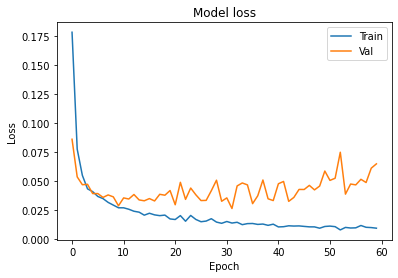

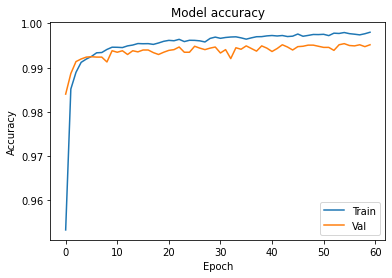

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("loss_train_electr_vs_gamma_5total.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.savefig("acc_train_electr_vs_gamma_5total.png")

plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(x_test, y_test)
# print(val_loss)
print(val_acc)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict_classes(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

370/370 [==============================] - 2s 6ms/step - loss: 0.0651 - accuracy: 0.9952
0.9951841831207275
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[ 1576    46]
 [   11 10203]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1622
         1.0       1.00      1.00      1.00     10214

    accuracy                           1.00     11836
   macro avg       0.99      0.99      0.99     11836
weighted avg       1.00      1.00      1.00     11836



In [ ]:
#guradamos el modelo
model.save("/content/drive/MyDrive/TFG arturo/CNN/model2_casi_5gamma.h5")

In [ ]:
#tenemos mucho problema de overfiting, pero creo que cuando consideramos menos datos para gamma esto no pasa

shape=[128,55,93,1]
model2=create_model()
model2.build(shape) 
model2.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (128, 55, 93, 32)         832       
_________________________________________________________________
conv2d_13 (Conv2D)           (128, 55, 93, 32)         25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (128, 27, 46, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (128, 27, 46, 64)         51264     
_________________________________________________________________
conv2d_15 (Conv2D)           (128, 27, 46, 64)         102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (128, 13, 23, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (128, 19136)             

In [ ]:
%%time
history=model2.fit(data_train, epochs=60,batch_size=128, validation_data=data_test)

Epoch 1/60

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

210/210 [==============================] - 14s 69ms/step - loss: 0.2780 - accuracy: 0.9180 - val_loss: 0.1091 - val_accuracy: 0.9700
Epoch 2/60
210/210 [==============================] - 14s 68ms/step - loss: 0.1254 - accuracy: 0.9734 - val_loss: 0.0783 - val_accuracy: 0.9800
Epoch 3/60
210/210 [==============================] - 14s 67ms/step - loss: 0.0879 - accuracy: 0.9808 - val_loss: 0.0630 - val_accuracy: 0.9861
Epoch 4/60
210/210 [==============================] - 14s 66ms/step - loss: 

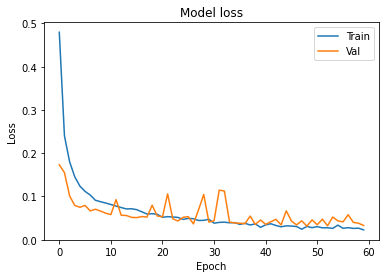

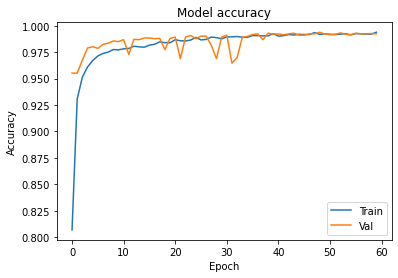

In [ ]:
#para solo 1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("loss_train_electr_vs_gamma_1sologamma.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.savefig("acc_train_electr_vs_gamma_1sologamma.png")

plt.show()

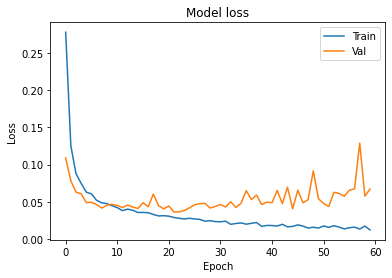

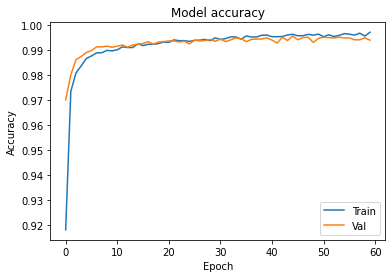

In [ ]:
#para 3
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig("/content/drive/MyDrive/TFG arturo/CNN/loss_train_electr_vs_gamma_3gamma_2.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.savefig("/content/drive/MyDrive/TFG arturo/CNN/acc_train_electr_vs_gamma_3gamma_2.png")

plt.show()

In [ ]:
val_loss, val_acc = model2.evaluate(data_test)
# print(val_loss)
print(val_acc)

from sklearn.metrics import classification_report, confusion_matrix
val_loss, val_acc = model2.evaluate(data_test)
y_pred = model2.predict_classes(data_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

53/53 [==============================] - 1s 19ms/step - loss: 0.0672 - accuracy: 0.9939
0.993884265422821
[[1585   37]
 [   4 5078]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1622
         1.0       0.99      1.00      1.00      5082

    accuracy                           0.99      6704
   macro avg       1.00      0.99      0.99      6704
weighted avg       0.99      0.99      0.99      6704



In [ ]:
model2.save("/content/drive/MyDrive/TFG arturo/CNN/model3_1gamma_2.h5")

In [ ]:
#estaría muy interesanter ver esos que han sido mal clasificado para saber porque
y_percent=model2.predict(X_test)
y_percent=y_percent[:,0][y_test!=y_pred]
y_pred_mal=y_pred[y_test!=y_pred]
errores=X_test_aux[y_test!=y_pred]

(40, 55, 93)

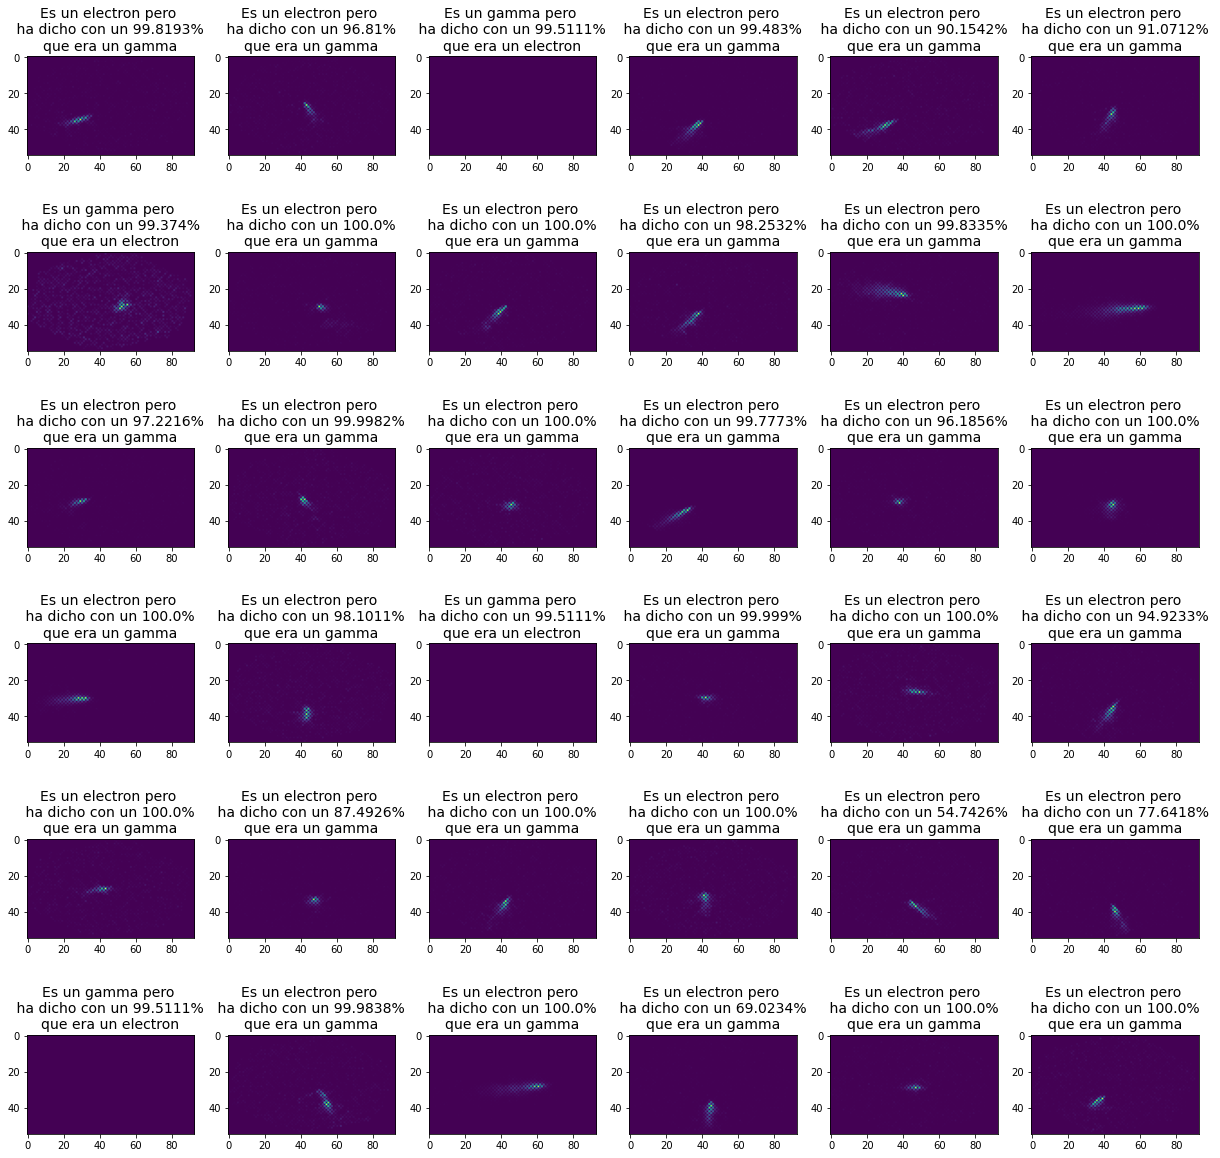

In [ ]:
plt.figure(figsize=(21,21))
for i in range(1,37):
  plt.subplot(6,6,i)
  num_mal=y_pred_mal[i]
  if num_mal==1 :
    nombre_bien="electron"
    nombre_mal="gamma"
    prob=round((1-y_percent[i])*100,4)
  elif num_mal==0:
    nombre_bien="gamma"
    nombre_mal="electron"
    prob=round((y_percent[i])*100,4)
  plt.title("Es un "+nombre_bien+" pero \n ha dicho con un "+str(prob)+"% \n"+"que era un "+nombre_mal, fontsize=14)
  plt.imshow(errores[i])
  #plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TFG arturo/CNN/falsos_predicts_electr_vs_gamma_3gamma_2.png")

plt.show()
plt.close()

## Que más se podría hacer?
Algunas de las cosas que quedan por concretar:


*   Explorar otras extructuras para la red CNN y otros hiperparámetros
*   En la parte estadística podemos intentar predecir mas o menos que extructura básica tienen las imágenes de cada partícula. El gamma se ve que casi siempre es un punto por el centro con un poco de rasto, el nitrogeno es un punto muy pequeño, el hierro creo que es más amplio etc... Alomejor esto se podría hacer de alguna manera con GANS? o con autoncoders para extraer estructuras básicas.
*   He observado que cargar el mismo numero de gammas y electrones para el entrenamiento es mejor que cargar 5 veces mas de gamma que de electrones y entrenar. Es como si la red necesitara mas o menos de las dos en igual medida,si no se acostumbra y luego falla. O algo así. ¿que es eso?¿semejante cantidad de todas las clases en el dataset para un mejor performance?



# Vamos a hacer un analisis de las intensidades por cada RUN


In [ ]:
#cargamos librerias 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import glob 
import re
import sys

##graficos
* Hay uno para las intensidades normal.
* Otro para la las intensidades con los negativos puesto como 0
* Otro considerando solo los que tienen 1 en la sexta columna

In [ ]:

ground_dir="/content/drive/MyDrive/TFG arturo"
elements=["gamma","electron","helium", "proton","iron","silicon","nitrogen"]

#para cada elemento cargamos los datos poco a poco y vamos generando los graficos de las boxes en un grafico comun para 
#cada elemento y mostramos todas las runs

#probamos pa uno/electornes
nombre_aux=ground_dir+"/"+elements[1]+"/"+"*.dt"
archivos_dt=glob.glob(nombre_aux)
plt.figure(figsize=(31,31))
for i,archivo in enumerate(archivos_dt):
  df=pd.read_csv(archivo,names=[1,2,3,4,5,6],sep="  ",engine="python")
  plt.subplot(round(np.sqrt(len(archivos_dt))),np.ceil(np.sqrt(len(archivos_dt))),i+1)
  ax0=plt.gca()
  df[5].plot(kind="line",ax=ax0,title="Run "+str(i))  
  #plt.title("Run "+str(i))
plt.show()

In [ ]:
df.head()

,1,2,3,4,5,6
0,700,1,10800,16200,0.9,0
1,700,1,10800,15816,2.3,0
2,700,1,11132,16008,0.4,0
3,700,1,11132,16392,-0.1,0
4,700,1,10800,16584,0.0,0


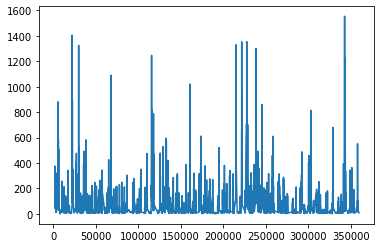

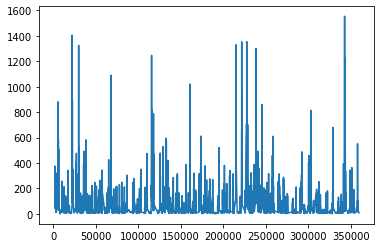

In [ ]:
df=pd.read_csv(archivos_dt[1],sep="  ",names=[1,2,3,4,5,6],engine="python")
df[5].loc[df[6]==1].plot(kind="line")

In [ ]:
print(df[5].loc[df[6]==1].shape)
print(df[5].loc[df[6]==0].shape)

In [ ]:
plt.figure()
df[5].loc[df[6]==1].plot(kind="line")

plt.figure()
df[5].loc[df[6]==0].plot(kind="line")


##Considerar solo los unos en la sexta columna

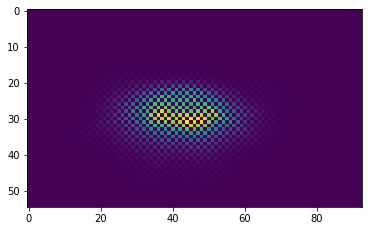

In [ ]:
ground_dir="/content/drive/MyDrive/TFG arturo"
save_dir="/content/drive/MyDrive/TFG arturo/stats_1/stats_solo_1_sextacolumna"
elements=["gamma","electron","helium", "proton","iron","silicon","nitrogen"]

#para cada elemento cargamos los datos poco a poco y vamos generando los graficos de las boxes en un grafico comun para 
#cada elemento y mostramos todas las runs

#probamos pa uno/electornes
nombre_aux=ground_dir+"/"+elements[0]+"/"+"*.dt"
archivos_dt=glob.glob(nombre_aux)
for i,archivo in enumerate(archivos_dt):
  #creamos una lista con un dataframe por cada archivo
  #dt_list=[]
  matrix_calor=np.zeros((60-5,131-38))
  aux_df=pd.read_csv(archivo,sep='  ',names=["1","2","3","4","5","6"],engine="python")
  #ahora la procesamos y la guardamos en un npy
  value_auf=aux_df[['1','3','4','5']].loc[aux_df["6"]==1].copy()
  del aux_df
  #tenemos que agupar los valores y normalizarlos 
  value_auf.loc[value_auf["5"]<0]=0
  max_aux=np.amax(value_auf["5"])
  value_auf["5"]=value_auf["5"]/max_aux
  x_minimo=min(value_auf['3'])
  y_minimo=min(value_auf['4'])
  value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/333)) #el 333 y el 192 viene de la distancia entre pixeles, no es para nada fortuito
  value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/192))
  event_aux=value_auf["1"].unique()
  for k in event_aux:
    #cada evento tiene que ponerse en una imagen con sus valores
    array_aux=value_auf.loc[value_auf["1"]==k][["3","4","5"]]
    #lo que vamos a hacer es qponer los valores en una matriz creada de antemano y guardar esa matrix
    #todo estos numeros 60, 5 , 131 etc son por las posiciones de lox pixeles, si miras los valores minimos y maximos y tal, son esos
    matrix_aux=np.zeros((60-5,131-38))
    matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy()
    #dt_list.append(matrix_aux)
    #en lugar de guardar un array con todos los eventos, vamosa hacer el mapa de calor directamente PARA CADA RUN
    matrix_calor+=matrix_aux
  del event_aux
  
  plt.imshow(matrix_calor)

  plt.savefig(save_dir+"/"+elements[1]+"_RUN_"+str(i)+".png")
  #ya tenemos el datafram con las cosas, ahora la procesamos y la guardamos en un npy
